In [1]:
import os
import glob
import pandas as pd

# 6score 的根目錄
root_dir = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score"

# 轉換 中文類別 → 整數 label
label_map = {
    "正常": 0,
    "異常": 1,
    "故障": 2,
}

rows = []

# 走過每一個 turnout 資料夾：P1602N, P1602R, ...
for device_name in os.listdir(root_dir):
    device_path = os.path.join(root_dir, device_name)
    if not os.path.isdir(device_path):
        continue

    # 走過三個子資料夾：正常 / 異常 / 故障
    for class_name in ["正常", "異常", "故障"]:
        class_folder = os.path.join(device_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        csv_paths = glob.glob(os.path.join(class_folder, "*.csv"))
        for path in csv_paths:
            rows.append({
                "file_path": path,
                "device": device_name,     # P1602N / P1602R / ...
                "class_name": class_name,  # 正常 / 異常 / 故障
                "label_idx": label_map[class_name],
            })

manifest = pd.DataFrame(rows)
print("總樣本數：", len(manifest))
display(manifest.head())

print("\n整體類別分布：")
print(manifest["class_name"].value_counts())


總樣本數： 4372


,file_path,device,class_name,label_idx
0,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
1,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
2,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
3,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
4,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0



整體類別分布：
class_name
正常    3222
異常    1028
故障     122
Name: count, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split

# 先做 manifest（跟之前一樣）
# manifest 需要有 device 和 class_name 兩欄

# 新增一個「分層 key」：設備 + 類別
manifest["strata"] = manifest["device"] + "_" + manifest["class_name"]

print("不同 (device, class) 組合數：", manifest["strata"].nunique())
print(manifest["strata"].value_counts())

# 1) 先切出 train (75%) 和 temp (25%)
train_df, temp_df = train_test_split(
    manifest,
    test_size=0.25,
    stratify=manifest["strata"],   # ← 用 strata 分層
    random_state=42,
)

# 2) 再把 temp 切成 val/test
# 想要：val = 10%, test = 15%  → 在 temp(25%) 裡：val: 0.4, test: 0.6
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.6,
    stratify=temp_df["strata"],    # ← 一樣用 strata 分層
    random_state=42,
)

# # 1) 第一刀：切出 Test (0.2) 和 Train_Val (0.8)
# train_val_df, test_df = train_test_split(
#     manifest,
#     test_size=0.2,               # 總體的 20% 給 Test
#     stratify=manifest["strata"], # 根據 strata 分層
#     random_state=42,
# )

# # 2) 第二刀：從 Train_Val (0.8) 中切出 Val (總體的 0.1)
# # 計算比例：想要 0.1 / 目前手上的 0.8 = 0.125
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.125,             # 0.125 * 0.8 = 0.1 (總體)
#     stratify=train_val_df["strata"],
#     random_state=42,
# )

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))
print("Total:     ", len(manifest))

print("\nTrain 類別分布：")
print(train_df["class_name"].value_counts())
print("\nVal 類別分布：")
print(val_df["class_name"].value_counts())
print("\nTest 類別分布：")
print(test_df["class_name"].value_counts())

print("\nTrain 設備分布：")
print(train_df["device"].value_counts())
print("\nVal 設備分布：")
print(val_df["device"].value_counts())
print("\nTest 設備分布：")
print(test_df["device"].value_counts())


不同 (device, class) 組合數： 16
strata
P1604R_正常    838
P1604N_正常    838
P1603N_正常    526
P1603R_正常    496
P1602N_正常    364
P1603R_異常    324
P1603N_異常    308
P1602R_異常    294
P1602R_正常    160
P1602N_異常    102
P1603N_故障     38
P1603R_故障     28
P1602R_故障     19
P1604N_故障     17
P1602N_故障     12
P1604R_故障      8
Name: count, dtype: int64
Train size: 3279
Val size:   437
Test size:  656
Total:      4372

Train 類別分布：
class_name
正常    2416
異常     772
故障      91
Name: count, dtype: int64

Val 類別分布：
class_name
正常    322
異常    102
故障     13
Name: count, dtype: int64

Test 類別分布：
class_name
正常    484
異常    154
故障     18
Name: count, dtype: int64

Train 設備分布：
device
P1603N    653
P1604N    641
P1603R    636
P1604R    635
P1602N    359
P1602R    355
Name: count, dtype: int64

Val 設備分布：
device
P1603N    88
P1604N    86
P1603R    85
P1604R    84
P1602N    47
P1602R    47
Name: count, dtype: int64

Test 設備分布：
device
P1603N    131
P1604N    128
P1604R    127
P1603R    127
P1602N     72
P1602R     71
Name: c

Device: cuda
正在載入 Scaler 和 BiLSTM 模型...
✅ Scaler 載入成功: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/BiLSTM/test/scaler.pkl
✅ BiLSTM 權重載入成功: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/BiLSTM/test/best_bilstm_model_test.pth
準備測試 656 筆資料...


/tmp/ipykernel_3956827/1498449268.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BILSTM_CKPT, map_location=device)



Classification Report (Re-loaded BiLSTM Model):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       484
           1       0.93      0.92      0.93       154
           2       0.89      0.89      0.89        18

    accuracy                           0.96       656
   macro avg       0.93      0.93      0.93       656
weighted avg       0.96      0.96      0.96       656



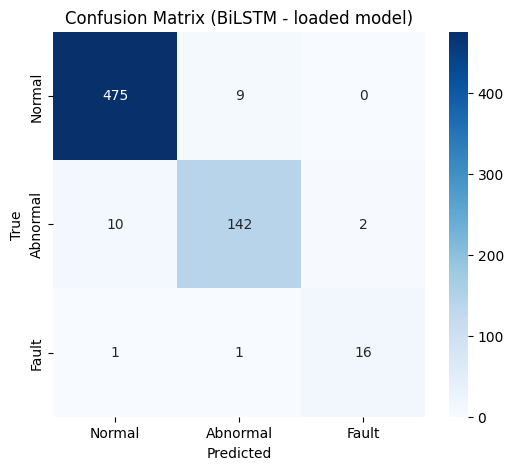

In [10]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import joblib  # 用來載入 Scaler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. 重新定義 BiLSTM 架構（必須跟訓練時一致）
# ==========================================
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.bilstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,  # ✅ BiLSTM
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        # ✅ BiLSTM 輸出是 2 * hidden_size（forward + backward）
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x, lengths):
        # pack: 忽略 padding
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        _, (h_n, _) = self.bilstm(packed_input)

        # h_n shape: (num_layers * 2, B, H)
        # 最後一層的 forward/backward hidden state
        # forward: h_n[-2], backward: h_n[-1]
        h_forward = h_n[-2]   # (B, H)
        h_backward = h_n[-1]  # (B, H)

        last_hidden = torch.cat([h_forward, h_backward], dim=1)  # (B, 2H)

        out = self.dropout(last_hidden)
        out = self.fc(out)  # (B, num_classes)
        return out


# ==========================================
# 2. 參數設定（請跟你 BiLSTM 訓練時一致）
# ==========================================
CONT_COLS = ["NCurrent", "RCurrent", "WRVT"]
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]

INPUT_SIZE = len(CONT_COLS) + len(BIN_CAT_COLS)  # 12
HIDDEN_SIZE = 64
NUM_LAYERS = 2
NUM_CLASSES = 3   # 正常0, 異常1, 故障2
DROPOUT = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ==========================================
# 3. 載入 Scaler + BiLSTM 權重
# ==========================================
print("正在載入 Scaler 和 BiLSTM 模型...")

SCALER_PATH = "/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/BiLSTM/test/scaler.pkl"
BILSTM_CKPT  = "/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/BiLSTM/test/best_bilstm_model_test.pth"
# ↑↑ 你把檔名換成你 BiLSTM 訓練存下來的 pth

try:
    scaler = joblib.load(SCALER_PATH)
    print("✅ Scaler 載入成功:", SCALER_PATH)
except FileNotFoundError:
    print("❌ 找不到 scaler.pkl，請確認路徑:", SCALER_PATH)
    raise

model = BiLSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT).to(device)

try:
    # state = torch.load(BILSTM_CKPT, map_location=device)
    # model.load_state_dict(state, strict=True)
    ckpt = torch.load(BILSTM_CKPT, map_location=device)
    state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
    model.load_state_dict(state_dict, strict=True)

    model.eval()
    print("✅ BiLSTM 權重載入成功:", BILSTM_CKPT)
except FileNotFoundError:
    print("❌ 找不到 BiLSTM checkpoint，請確認路徑:", BILSTM_CKPT)
    raise
except RuntimeError as e:
    print("❌ 權重載入失敗（通常是架構/hidden_size/num_layers/雙向設定不同）")
    print("錯誤訊息：", e)
    raise


# ==========================================
# 4. Dataset + collate_fn（沿用你原本 LSTM 的）
# ==========================================
class EventDataset(Dataset):
    def __init__(self, manifest_df, cont_cols, bin_cat_cols, scaler):
        self.manifest = manifest_df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.bin_cat_cols = bin_cat_cols
        self.scaler = scaler

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        path = row["file_path"]
        label = int(row["label_idx"])

        df = pd.read_csv(path)
        for c in self.cont_cols + self.bin_cat_cols:
            if c not in df.columns:
                df[c] = 0.0

        # scaler: 只對連續欄位做 transform
        if self.scaler is not None and not df[self.cont_cols].empty:
            df[self.cont_cols] = self.scaler.transform(df[self.cont_cols])

        feats = []
        for c in self.cont_cols:
            vals = df[c].values.astype(np.float32)
            feats.append(torch.from_numpy(vals).unsqueeze(1))
        for c in self.bin_cat_cols:
            vals = df[c].fillna(0).astype(int).clip(0, 1).values.astype(np.float32)
            feats.append(torch.from_numpy(vals).unsqueeze(1))

        features_tensor = torch.cat(feats, dim=1)  # (T, F)
        return {
            "features": features_tensor,
            "length": features_tensor.shape[0],
            "label": torch.tensor(label, dtype=torch.long),
        }

def collate_fn(batch):
    batch = [item for item in batch if item["length"] > 0]
    if not batch:
        return {}

    features_list = [item["features"] for item in batch]
    lengths_list = [item["length"] for item in batch]
    labels_list = [item["label"] for item in batch]

    padded_features = pad_sequence(features_list, batch_first=True, padding_value=0.0)  # (B, T_max, F)
    return {
        "features": padded_features,
        "lengths": torch.tensor(lengths_list, dtype=torch.long),
        "labels": torch.stack(labels_list),
    }


# ==========================================
# 5. 需要 test_df（跟你原本一樣）
# ==========================================
if 'test_df' not in locals():
    print("⚠️ 注意：你需要先生成 test_df（manifest split 那段要先跑完）")
else:
    print(f"準備測試 {len(test_df)} 筆資料...")
    test_dataset = EventDataset(test_df, CONT_COLS, BIN_CAT_COLS, scaler)
    test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=collate_fn)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            if not batch:
                continue
            features = batch["features"].to(device)
            lengths = batch["lengths"].to(device) # 這裡留 CPU 也行（pack 用 lengths.cpu()）
            labels = batch["labels"].to(device)

            outputs = model(features, lengths)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report (Re-loaded BiLSTM Model):")
    print(classification_report(all_labels, all_preds, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Abnormal", "Fault"],
                yticklabels=["Normal", "Abnormal", "Fault"])
    plt.title("Confusion Matrix (BiLSTM - loaded model)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [11]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample

# 你的 cell 3 已經有 all_labels, all_preds
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

LABELS = [0, 1, 2]   # 正常/異常/故障
FAULT_LABEL = 2
n_iterations = 1000
alpha = 0.95

stats_acc = []
stats_f1_macro = []
stats_f1_fault = []

for i in range(n_iterations):
    sample_true, sample_pred = resample(
        y_true, y_pred,
        replace=True,
        random_state=i
    )

    # accuracy
    stats_acc.append(accuracy_score(sample_true, sample_pred))

    # macro f1（固定 labels，避免某次抽樣缺某類）
    stats_f1_macro.append(
        f1_score(sample_true, sample_pred,
                average="macro",
                labels=LABELS,
                zero_division=0)
    )

    # fault f1
    f1_pc = f1_score(sample_true, sample_pred,
                    average=None,
                    labels=LABELS,
                    zero_division=0)
    stats_f1_fault.append(f1_pc[FAULT_LABEL])

stats_acc = np.array(stats_acc)
stats_f1_macro = np.array(stats_f1_macro)
stats_f1_fault = np.array(stats_f1_fault)

p = ((1.0 - alpha) / 2.0) * 100
lo, hi = p, 100 - p

acc_lo, acc_hi = np.percentile(stats_acc, [lo, hi])
m_lo, m_hi = np.percentile(stats_f1_macro, [lo, hi])
f_lo, f_hi = np.percentile(stats_f1_fault, [lo, hi])

print("======== BiLSTM Bootstrap 95% Confidence Intervals ========")
print(f"Accuracy 95% CI : {stats_acc.mean():.4f} [{acc_lo:.4f}, {acc_hi:.4f}]")
print(f"Macro F1 95% CI : {stats_f1_macro.mean():.4f} [{m_lo:.4f}, {m_hi:.4f}]")
print(f"Fault F1 95% CI : {stats_f1_fault.mean():.4f} [{f_lo:.4f}, {f_hi:.4f}]")


======== BiLSTM Bootstrap 95% Confidence Intervals ========
Accuracy 95% CI : 0.9650 [0.9497, 0.9787]
Macro F1 95% CI : 0.9315 [0.8801, 0.9692]
Fault F1 95% CI : 0.8872 [0.7500, 0.9767]


In [ ]:
import matplotlib.pyplot as plt
import joblib

# 1. 載入訓練紀錄
try:
    history = joblib.load('/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test/history.pkl')
    print("✅ 成功載入訓練紀錄 (history.pkl)")
except FileNotFoundError:
    print("❌ 找不到 history.pkl，請確認是否有執行過訓練並存檔。")
    # 為了避免程式報錯，這裡做個假資料 (實際使用時會被 exit 擋下)
    history = None
    exit()

# 2. 開始畫圖
if history:
    epochs = range(1, len(history["train_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # ---- Loss Curve ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label="Train Loss")
    plt.plot(epochs, history["val_loss"],   'r--', label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---- Accuracy Curve ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], 'b-', label="Train Acc")
    plt.plot(epochs, history["val_acc"],   'r--', label="Val Acc")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

❌ 找不到 history.pkl，請確認是否有執行過訓練並存檔。


: 